# RNN을 이용한 SMS Spam 분류
- 캐글에서 제공하는 [스팸메일데이터](https://www.kaggle.com/uciml/sms-spam-collection-dataset)

In [ ]:
# 한글폰트

In [ ]:
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

In [ ]:
# 설치뒤에 font-manager rebuild
# import matplotlib.font_manager as fm
# fm._rebuild()

런타임에서 다시 시작

## 1. 데이터 전처리

In [ ]:
# from google.colab import files
# uploaded_file = files.upload()
# filename = list(uploaded_file.keys())[0]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font',family='NanumGothic')

In [ ]:
seed = 2021
np.random.seed(seed)

In [ ]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_csv('spam.csv', encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
del df['Unnamed: 2']
del df['Unnamed: 3']
del df['Unnamed: 4']
# 수동 Label Encoding 
df['v1'] = df['v1'].replace(['ham','spam'],[0,1])
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [ ]:
# Null 값을 가진 샘플이 있는지 확인
df.isnull().values.any()

False

In [ ]:
# 중복데이터 확인
df.nunique()

v1       2
v2    5169
dtype: int64

In [ ]:
# 데이터 중복 제거
df = df.drop_duplicates('v2',keep='first')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5169 non-null   int64 
 1   v2      5169 non-null   object
dtypes: int64(1), object(1)
memory usage: 121.1+ KB


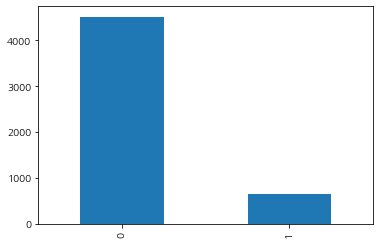

In [ ]:
df.v1.value_counts().plot(kind='bar');

In [ ]:
df.v1.value_counts()

0    4516
1     653
Name: v1, dtype: int64

In [ ]:
X_data = df['v2'].values
y_data = df['v1'].values
print(f'SMS 본문의 개수 : {len(X_data)}')
print(f'레이블의 개수 : {len(y_data)}')

SMS 본문의 개수 : 5169
레이블의 개수 : 5169


In [ ]:
  from string import punctuation
  punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# 구두점 제거와 소문자화를 위한 함수
def repreprocessing(s):
    s=s.encode("utf8").decode("ascii", 'ignore')
    return ''.join(c for c in s if c not in punctuation).lower()

In [ ]:
X_puc = [repreprocessing(x) for x in df['v2'].values]
X_puc[:5]

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat',
 'ok lar joking wif u oni',
 'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s',
 'u dun say so early hor u c already then say',
 'nah i dont think he goes to usf he lives around here though']

In [ ]:
X_data[:5]

array(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
       'Ok lar... Joking wif u oni...',
       "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
       'U dun say so early hor... U c already then say...',
       "Nah I don't think he goes to usf, he lives around here though"],
      dtype=object)

In [ ]:
t = Tokenizer()
t.fit_on_texts(X_puc)
sequences = t.texts_to_sequences(X_puc)
vocab_size = len(t.word_index) + 1
print(f'단어집합의 크기 : {vocab_size}')

단어집합의 크기 : 9480


In [ ]:
t = Tokenizer()
t.fit_on_texts(X_data)
sequences = t.texts_to_sequences(X_data)
vocab_size = len(t.word_index) + 1
print(f'단어집합의 크기 : {vocab_size}')

단어집합의 크기 : 8921


- punctuation를 진행하고 나서 사용하면 단어집합의 크기가 오히려 늘어남 
- 원본으로 사용

In [ ]:
# 단어에 대한 인덱스
word_to_index = t.word_index
len(word_to_index)

8920

## 전체 단어 집합에서 희소 단어의 비율


In [ ]:
threshold = 2
total_cnt = len(word_to_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in t.word_counts.items():
    total_freq = total_freq + value

    if value < threshold :
        rare_cnt += 1
        rare_freq += value

print(f'등장 빈도가 {threshold - 1}번 이하인 희귀 단어의 수 : {rare_cnt}')
print(f'단어집합에서 희귀 단어의 수 : {(rare_cnt / total_cnt)*100}')
print(f'전체 등장 빈도에서 희귀 단어의 수 : {(rare_freq / total_freq)*100}')

등장 빈도가 1번 이하인 희귀 단어의 수 : 4908
단어집합에서 희귀 단어의 수 : 55.02242152466368
전체 등장 빈도에서 희귀 단어의 수 : 6.082538108811501


SMS의 최대 길이 : 189
SMS의 평균 길이 : 15.610370


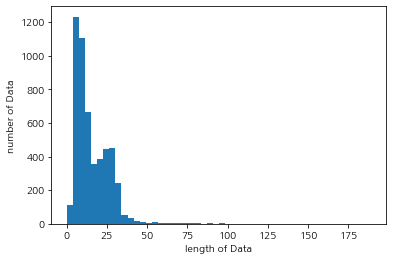

In [ ]:
X_data = sequences
max_len = max(len(l) for l in X_data)
print('SMS의 최대 길이 : %d' % max_len)
print('SMS의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))

plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [ ]:
# 전체 데이터셋의 길이를 max_len(189)에 맞춤
data = pad_sequences(X_data, maxlen=max_len)
data.shape

(5169, 189)

In [ ]:
# 테스트용 데이터 20% 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, y_data, test_size = .2, random_state = 2021
)

In [ ]:
X_train.shape, y_train.shape

((4135, 189), (4135,))

## 2. 모델 설계 및 학습

In [ ]:
from keras.layers import SimpleRNN, Dense, Embedding
from keras.models import Sequential

In [ ]:
model = Sequential([
    Embedding(vocab_size, 32),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          285472    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 287,585
Trainable params: 287,585
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# 훈련용 데이터중 20%를 검증 데이터로 사용
history = model.fit(X_train,y_train, epochs=10,
                    batch_size=60,validation_split=0.2,verbose=2)

Epoch 1/10
56/56 [==============================] - 4s 47ms/step - loss: 0.3682 - accuracy: 0.8516 - val_loss: 0.1409 - val_accuracy: 0.9637
Epoch 2/10
56/56 [==============================] - 2s 44ms/step - loss: 0.0958 - accuracy: 0.9784 - val_loss: 0.0702 - val_accuracy: 0.9770
Epoch 3/10
56/56 [==============================] - 2s 43ms/step - loss: 0.0850 - accuracy: 0.9713 - val_loss: 0.0560 - val_accuracy: 0.9843
Epoch 4/10
56/56 [==============================] - 2s 44ms/step - loss: 0.0308 - accuracy: 0.9925 - val_loss: 0.0436 - val_accuracy: 0.9867
Epoch 5/10
56/56 [==============================] - 2s 43ms/step - loss: 0.0215 - accuracy: 0.9948 - val_loss: 0.0359 - val_accuracy: 0.9879
Epoch 6/10
56/56 [==============================] - 2s 43ms/step - loss: 0.0155 - accuracy: 0.9946 - val_loss: 0.0627 - val_accuracy: 0.9831
Epoch 7/10
56/56 [==============================] - 2s 39ms/step - loss: 0.0468 - accuracy: 0.9863 - val_loss: 0.0582 - val_accuracy: 0.9867
Epoch 8/10
56

In [ ]:
# 테스트 정확도
print(f'테스트 정확도 : {model.evaluate(X_test, y_test, verbose=0)[1]:.4f}')

테스트 정확도 : 0.9720


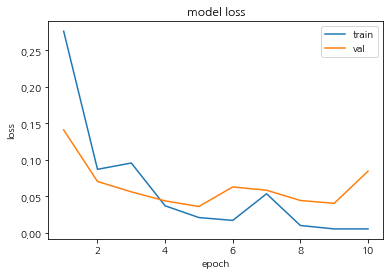

In [ ]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()